Karla Jacobo  
DSCI 8950  
AI/ML Independent Study Report

### Isolation Forest  

I am going to start off by importing any necessary packages for running the Isolation Forest and Catboost models. I will also be importing the small dataset I have selected for this assignment. The dataset I have selected is one I got from Kaggle here: https://www.kaggle.com/datasets/himelsarder/cinema-hall-ticket-sales-and-customer-behavior?resource=download.
Because it has data regarding movie goer behavior, it is a good fit for anomaly detection.

In [2]:
import pandas as pd
import numpy as np
import collections
from sklearn.ensemble import IsolationForest
from catboost import CatBoostRegressor
import matplotlib.pyplot as plt

movieData = pd.read_csv('data/cinema_hall_ticket_sales.csv')
allDataTypes = []

print(f'{str(movieData.head(3))}')
print('-----------------------------------')

print(f'MovieData table size: {str(movieData.shape[0])} rows, {str(movieData.shape[1])} columns')

print('-----------------------------------')

null_data = movieData[movieData.isnull().any(axis=1)]
print(f'There are {str(null_data.shape[0])}/{str(movieData.shape[0])} rows missing data.')

print('-----------------------------------')
dataTypes = movieData.dtypes.values
for type in dataTypes:
    allDataTypes.append(str(np.dtype(type)))

print(collections.Counter(allDataTypes))

  Ticket_ID  Age  Ticket_Price Movie_Genre Seat_Type Number_of_Person  \
0     N4369   55         12.27      Comedy  Standard                7   
1     B8091   35         19.02       Drama  Standard            Alone   
2     V6341   55         22.52      Horror       VIP                3   

  Purchase_Again  
0             No  
1            Yes  
2             No  
-----------------------------------
MovieData table size: 1440 rows, 7 columns
-----------------------------------
There are 0/1440 rows missing data.
-----------------------------------
Counter({'object': 5, 'int64': 1, 'float64': 1})


In the block above, we can see:  
    &nbsp;&nbsp;&nbsp;&nbsp;- The table column headers  
    &nbsp;&nbsp;&nbsp;&nbsp;- The dimensions of the table  
    &nbsp;&nbsp;&nbsp;&nbsp;- The the types of data featured in the table with how often they appear  

Now that we have the table imported and have verified there is no missing data, we can begin applying the Isolation Forest algorithm to the dataset.

27 anomalies detected out of 1440 rows of data

Sample of anomalous data entries: 
      Age  anomaly_value  anomaly_score
79    18             -1      -0.020988
164   18             -1      -0.020988
193   18             -1      -0.020988
-----------------------------------
Sample of normal data entries: 
    Age  anomaly_value  anomaly_score
0   55              1       0.083646
1   35              1       0.106619
2   55              1       0.083646


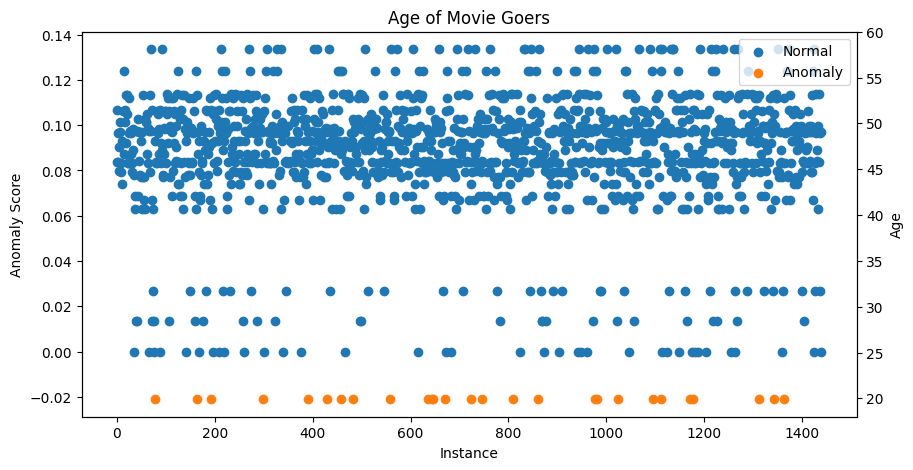

<Figure size 500x500 with 0 Axes>

<Figure size 500x500 with 0 Axes>

In [69]:
n_estimators = 100 # This is the number of of trees to build
contamination = 0.02 # This is the amount of contamination that is allowed

ageData = movieData[['Age']]

isolation_forest = IsolationForest(n_estimators=n_estimators,contamination=contamination)
analysisData = isolation_forest.fit(ageData)

analysisData = ageData.copy()
analysisData['anomaly_value'] = isolation_forest.predict(ageData)
analysisData['anomaly_score'] = isolation_forest.decision_function(ageData)
anomalyData = analysisData[analysisData['anomaly_value'] != 1]
normalData = analysisData[analysisData['anomaly_value'] == 1]

print(f'{anomalyData.shape[0]} anomalies detected out of {analysisData.shape[0]} rows of data')
print()
print(f'Sample of anomalous data entries: \n {anomalyData.head(3)}')

print('-----------------------------------')
print(f'Sample of normal data entries: \n {normalData.head(3)}')

normal = analysisData[analysisData['anomaly_value'] == 1]
anomalies = analysisData[analysisData['anomaly_value'] == -1]
sortedData = analysisData.sort_values(by = 'Age', ascending=True)
youngest = sortedData.iloc[0, sortedData.columns.get_loc('Age')]
oldest = sortedData.iloc[-1, sortedData.columns.get_loc('Age')]

fig, ax1 = plt.subplots(figsize=(10, 5))
ax2 = ax1.twinx()
ax1.scatter(normal.index, normal['anomaly_score'], label='Normal')
ax1.scatter(anomalies.index, anomalies['anomaly_score'], label='Anomaly')
ax2.set_ylim(youngest, oldest)

ax1.set_ylabel("Anomaly Score")
ax1.set_xlabel("Instance")
ax1.legend(loc = 'upper right')
ax2.set_ylabel("Age")

plt.title("Age of Movie Goers")
plt.show()

plt.figure(figsize=(5, 5))

We can see in the code above two variables are named and given to the Isolation Forest model: n_estimators and contamination. N_estimators establishes how many trees are going to be made. Contamination establishes how much of our dataset we expect to contain anomalies. Anomalies are identified by the number -1 in the anomaly_value column. Normal values are the number 1. I set this one to 0.02 because if it were any lower or higher, either too many or no anomalies would be detected. I was able to determine that by manually tuning the model.

As a result, we can see that 27 anomalies were detected in the Age column. Given the results of the model and the ages in the table, 18 year olds seem to be less likely to go see movies and are thus the outlier in this dataset.

### CatBoost  

By utilizing CatBoost's regression capabilities, we can give it the Age and Ticket Price data from our movie dataset to see if there is any correlation.

In [83]:
sampleData = movieData[['Age', 'Ticket_Price']]
sample_size = int(sampleData.shape[0] * 0.2) # Getting training data from 20% of the entire dataset
sampleData = sampleData.sample(sample_size, ignore_index=True)

training_data = [] #Getting the data into an array format
training_data.append(sampleData['Age'].values.tolist())
training_data.append(sampleData['Ticket_Price'].values.tolist())

evaluation_data = [] #Getting the data into an array format
evaluation_data.append(movieData['Age'].values.tolist())
evaluation_data.append(movieData['Ticket_Price'].values.tolist())

training_labels = [0, 1]

model = CatBoostRegressor(iterations=2)
model.fit(training_data, training_labels)
model.predict(evaluation_data)
model.get_best_score()


Learning rate set to 0.5
0:	learn: 0.4375000	total: 1.28ms	remaining: 1.28ms
1:	learn: 0.3828125	total: 2.77ms	remaining: 0us


{'learn': {'RMSE': 0.3828125}}

In the block of code above, we can se that the original dataset had to be manipulated into an array of arrays, also known as a matrix. This is because when the model is being fit, that is the format it expects the training data and labels to be in. Once the data is tailored to how the model expects it, we can call the .fit(), .predict(), and the .get_best_score() methods.

I chose to give the .fit() method a sample of two numerical columns from the original dataset. This sample is the size of 20% of the original dataset. Once the sample was selected, each column was turned into an array and added to the .fit() method along with numerical values for the training label definition. The .predict() method is run with the evaluation data. In this case I chose to use the entirety of the dataset. I am not sure if this is best practice. After that, I called the .get_best_score() method. This gets us the RMSE (Root Mean Square Error) value of the model, which is "most commonly used measures for evaluating the quality of predictions" (c3.ai). Generally, the lower the RMSE score is, the more accurate the better the model is. Given that the RMSE score here is 0.38, this particular model may have been overfitted.

### Sources Used for Assistance

https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.IsolationForest.html  
https://www.datacamp.com/tutorial/isolation-forest  
https://catboost.ai/docs/en/concepts/python-reference_catboostregressor  
https://catboost.ai/docs/en/concepts/python-usages-examples
https://c3.ai/glossary/data-science/root-mean-square-error-rmse/#:~:text=What%20is%20Root%20Mean%20Square,commonly%20used%20over%20standardized%20data